In [1]:
# import necessary packages and libraries 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  # Corrected this line
import xarray as xr
import numpy as np
import os 
from datetime import datetime

In [2]:
# --- Configuration ---

# New ratio to convert GLDAS data from kg/m^2 to cm
KG_M2_TO_CM_RATIO = 0.1

# Input the file path to your main data directory
# Using r'' is a safer way to write Windows paths
BASE_DIR = r'D:\Groundwater Vulnerability Mapping\data'

# Default figure size for plots
FIG_SIZE = (10, 10)

In [3]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

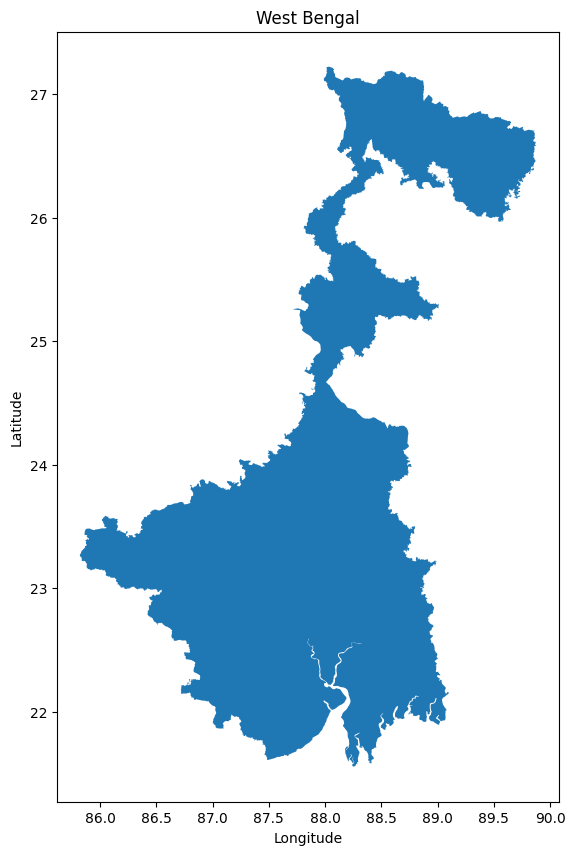

In [4]:
# Read the shapefile
basin_shapefile = gpd.read_file(os.path.join(BASE_DIR, r'shapefiles\West Bengal\West_Bengal.shp'))

# Reproject to standard latitude-longitude (WGS84)
basin_shapefile = basin_shapefile.to_crs(epsg=4326)

# Plot of entire West Bengal
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
add_labels(ax, 'West Bengal')

Longitude min: 85.81970749436145
Latitude min: 21.556115085291218
Longitude max: 89.87425124571746
Latitude max: 27.221013671249814


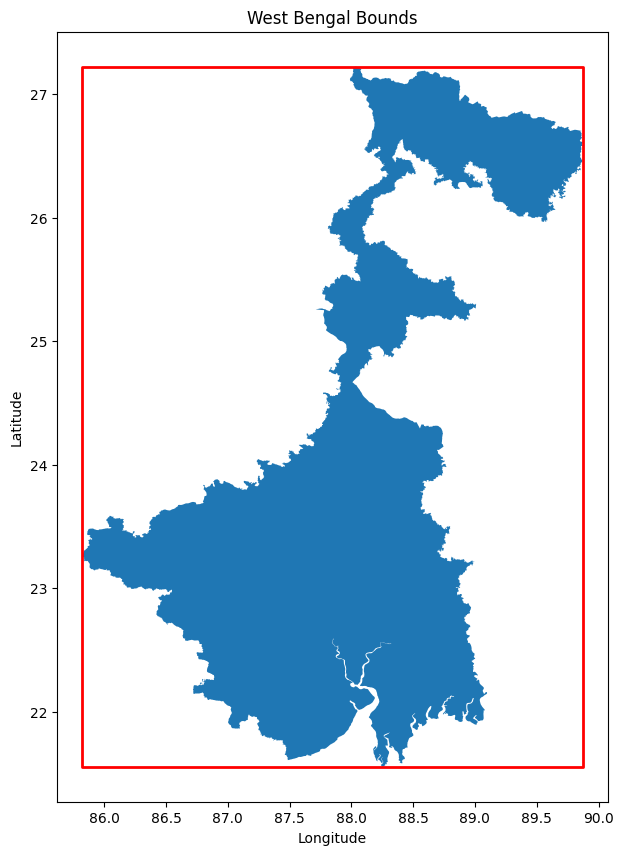

In [5]:
# Here, we use geopandas.GeoSeries.total_bounds
[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'West Bengal Bounds')
print(f"Longitude min: {lon_min}")
print(f"Latitude min: {lat_min}")
print(f"Longitude max: {lon_max}")
print(f"Latitude max: {lat_max}")

In [11]:
import pandas as pd

# --- Step 1: Define filenames ---
noah_file = 'grace_gldas_NOAH_final_merged_cm.csv'
clsm_file = 'grace_gldas_CLSM_final_merged_cm.csv'
vic_file = 'grace_gldas_VIC_final_merged_cm.csv'

# --- Step 2: Load the datasets ---
print("Loading the three processed datasets...")
df_noah = pd.read_csv(noah_file)
df_clsm = pd.read_csv(clsm_file)
df_vic = pd.read_csv(vic_file)

for df in [df_noah, df_clsm, df_vic]:
    df['time'] = pd.to_datetime(df['time'])

# --- Step 3: Select and Rename Columns ---
print("Preparing and renaming model-specific columns...")
merge_keys = ['time', 'lat', 'lon']

# THE FIX: Add 'uncertainty_cm' and 'scale_factor' to the list of columns to keep
noah_cols_to_keep = merge_keys + ['lwe_thickness_cm', 'uncertainty_cm', 'scale_factor', 'TotalSoilMoisture_cm', 'SWE_cm', 'Qs_acc_cm']
df_noah_renamed = df_noah[noah_cols_to_keep].rename(columns={
    'TotalSoilMoisture_cm': 'SMS_noah_cm',
    'SWE_cm': 'SWE_noah_cm',
    'Qs_acc_cm': 'Runoff_noah_cm'
})

# For CLSM, select and rename
df_clsm_subset = df_clsm[merge_keys + ['TotalSoilMoisture_cm', 'SWE_cm', 'Qs_acc_cm']].rename(columns={
    'TotalSoilMoisture_cm': 'SMS_clsm_cm',
    'SWE_cm': 'SWE_clsm_cm',
    'Qs_acc_cm': 'Runoff_clsm_cm'
})

# For VIC, select and rename
df_vic_subset = df_vic[merge_keys + ['TotalSoilMoisture_cm', 'SWE_cm', 'Qs_acc_cm']].rename(columns={
    'TotalSoilMoisture_cm': 'SMS_vic_cm',
    'SWE_cm': 'SWE_vic_cm',
    'Qs_acc_cm': 'Runoff_vic_cm'
})

# --- Step 4: Perform the merges ---
print("Merging the datasets...")
ensemble_df = df_noah_renamed
ensemble_df = pd.merge(ensemble_df, df_clsm_subset, on=merge_keys, how='left')
ensemble_df = pd.merge(ensemble_df, df_vic_subset, on=merge_keys, how='left')

# --- Step 5: Save and preview the result ---
output_filename = 'gldas_ensemble_merged_data_clean.csv'
ensemble_df.to_csv(output_filename, index=False)

print(f"\n✅ Merge complete! The clean dataset has been saved to '{output_filename}'")
print("\n--- Preview of the Final Clean Ensemble Data ---")
print(ensemble_df.head())

Loading the three processed datasets...
Preparing and renaming model-specific columns...
Merging the datasets...

✅ Merge complete! The clean dataset has been saved to 'gldas_ensemble_merged_data_clean.csv'

--- Preview of the Final Clean Ensemble Data ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SMS_noah_cm  SWE_noah_cm  Runoff_noah_cm  SMS_clsm_cm  \
0      0.967227    43.405443          0.0        0.000402    20.568842   
1      1.054784    48.309521          0.0        0.001563    21.996770   
2      1.054784    48.827573          0.0        0.001381    21.996770   
3      0

In [13]:
import pandas as pd

# --- Step 1: Load the clean, merged data from the previous step ---
ensemble_file = 'gldas_ensemble_merged_data_clean.csv'
ensemble_df = pd.read_csv(ensemble_file)

# --- Step 2: Define the columns to be averaged for each variable ---
sms_cols = ['SMS_noah_cm', 'SMS_clsm_cm', 'SMS_vic_cm']
swe_cols = ['SWE_noah_cm', 'SWE_clsm_cm', 'SWE_vic_cm']
runoff_cols = ['Runoff_noah_cm', 'Runoff_clsm_cm', 'Runoff_vic_cm']

# --- Step 3: Calculate the ensemble average for each variable ---
print("Calculating ensemble averages...")
ensemble_df['SMS_ensemble_cm'] = ensemble_df[sms_cols].mean(axis=1)
ensemble_df['SWE_ensemble_cm'] = ensemble_df[swe_cols].mean(axis=1)
ensemble_df['Runoff_ensemble_cm'] = ensemble_df[runoff_cols].mean(axis=1)

print("\n✅ Ensemble average calculation complete.")
print("\n--- Preview of the new ensemble columns ---")

# Show the original model columns and the new averaged column
print(ensemble_df.head())

Calculating ensemble averages...

✅ Ensemble average calculation complete.

--- Preview of the new ensemble columns ---
                  time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0  2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1  2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2  2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3  2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4  2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SMS_noah_cm  SWE_noah_cm  Runoff_noah_cm  SMS_clsm_cm  \
0      0.967227    43.405443          0.0        0.000402    20.568842   
1      1.054784    48.309521          0.0        0.001563    21.996770   
2      1.054784    48.827573          0.0        0.001381    21.996770   
3      0.955446    48.827573          0.0        0.001381    21.996770   
4      1.280962    62.480733          0.0        0.000925    25.6

In [14]:
# Define a name for the new file
output_filename = 'gldas_ensemble_averages_cm.csv'

# Save the ensemble_df which now contains the new average columns
ensemble_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the ensemble average data to '{output_filename}'")

✅ Successfully saved the ensemble average data to 'gldas_ensemble_averages_cm.csv'


In [16]:
import pandas as pd

# --- Step 1: Load the file with the ensemble averages ---
ensemble_file = 'gldas_ensemble_averages_cm.csv'
ensemble_df = pd.read_csv(ensemble_file)
ensemble_df['time'] = pd.to_datetime(ensemble_df['time'])

# --- Step 2: Calculate the long-term mean for each ensemble variable ---
print("Calculating the long-term mean for each ensemble variable...")
average_df = ensemble_df.groupby(['lat','lon']).agg({
    'SMS_ensemble_cm': 'mean',
    'SWE_ensemble_cm': 'mean',
    'Runoff_ensemble_cm': 'mean'
}).reset_index()

average_df = average_df.rename(columns={
    'SMS_ensemble_cm': 'SMS_ensemble_mean_cm',
    'SWE_ensemble_cm': 'SWE_ensemble_mean_cm',
    'Runoff_ensemble_cm': 'Runoff_ensemble_mean_cm'
})

# --- Step 3: Merge the means back and calculate the anomaly ---
print("Calculating anomalies...")
final_df = ensemble_df.merge(average_df, on=['lat','lon'], how='left')

final_df['SMS_ensemble_anomaly_cm'] = final_df['SMS_ensemble_cm'] - final_df['SMS_ensemble_mean_cm']
final_df['SWE_ensemble_anomaly_cm'] = final_df['SWE_ensemble_cm'] - final_df['SWE_ensemble_mean_cm']
final_df['Runoff_ensemble_anomaly_cm'] = final_df['Runoff_ensemble_cm'] - final_df['Runoff_ensemble_mean_cm']

print("\n✅ Ensemble anomaly calculation complete.")
print("\n--- Preview of the new ensemble anomaly columns ---")
print(final_df.head())

Calculating the long-term mean for each ensemble variable...
Calculating anomalies...

✅ Ensemble anomaly calculation complete.

--- Preview of the new ensemble anomaly columns ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SMS_noah_cm  SWE_noah_cm  Runoff_noah_cm  SMS_clsm_cm  ...  \
0      0.967227    43.405443          0.0        0.000402    20.568842  ...   
1      1.054784    48.309521          0.0        0.001563    21.996770  ...   
2      1.054784    48.827573          0.0        0.001381    21.996770  ...   
3      0.955446    48.827573          0.0        0.001381    21.

In [17]:
# The DataFrame 'final_df' is assumed to be in memory from the previous step.

# --- Step 1: Calculate Groundwater Storage (GWS) Anomaly in cm ---
# GWS Anomaly = TWS Anomaly - (Ensemble SMS Anomaly + Ensemble SWE Anomaly + Ensemble Runoff Anomaly)
print("Calculating the final GWS anomaly using ensemble data...")

final_df['GWS_ensemble_anomaly_cm'] = final_df['lwe_thickness_cm'] - (
    final_df['SMS_ensemble_anomaly_cm'] + 
    final_df['SWE_ensemble_anomaly_cm'] + 
    final_df['Runoff_ensemble_anomaly_cm']
)

print("\n✅ Final GWS Anomaly calculation complete.")

# --- Step 2: Save the final results to a new file ---
output_filename = 'GWS_Ensemble_Final_Results_cm.csv'
final_df.to_csv(output_filename, index=False)
print(f"Final results saved successfully to '{output_filename}'")


# --- Step 3: Preview the final result ---
print("\n--- Preview of Final Data with Ensemble GWS Anomaly ---")

print(final_df.head())

Calculating the final GWS anomaly using ensemble data...

✅ Final GWS Anomaly calculation complete.
Final results saved successfully to 'GWS_Ensemble_Final_Results_cm.csv'

--- Preview of Final Data with Ensemble GWS Anomaly ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SMS_noah_cm  SWE_noah_cm  Runoff_noah_cm  SMS_clsm_cm  ...  \
0      0.967227    43.405443          0.0        0.000402    20.568842  ...   
1      1.054784    48.309521          0.0        0.001563    21.996770  ...   
2      1.054784    48.827573          0.0        0.001381    21.996770  ...   
3      0.955446 

Generating the final time-series plot...


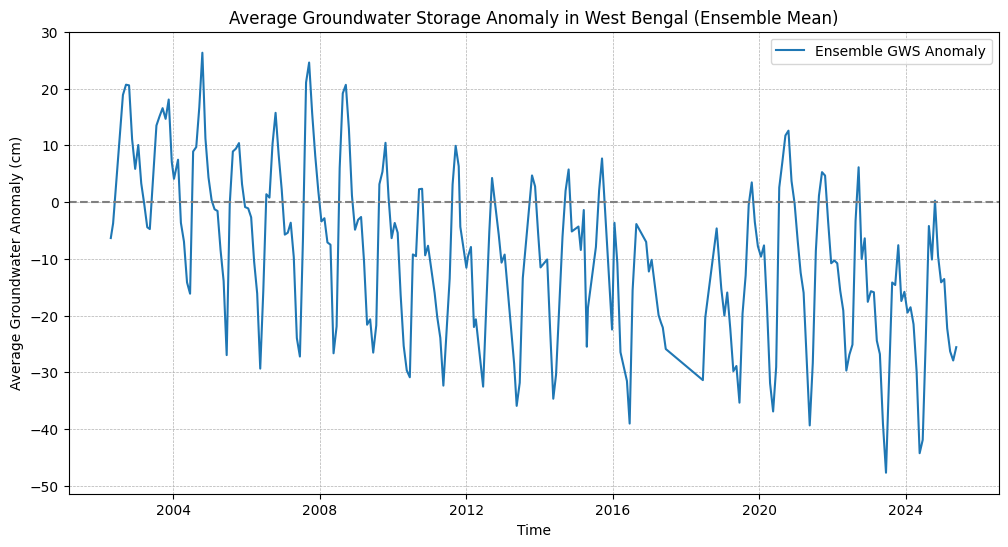

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final ensemble results file ---
final_file = 'GWS_Ensemble_Final_Results_cm.csv'
final_df = pd.read_csv(final_file)
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = final_df.groupby('time')['GWS_ensemble_anomaly_cm'].mean().reset_index()

# --- Step 3: Create the plot ---
print("Generating the final time-series plot...")

plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(gws_basin_avg['time'], gws_basin_avg['GWS_ensemble_anomaly_cm'], label='Ensemble GWS Anomaly')

# Add a baseline and formatting
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Average Groundwater Storage Anomaly in West Bengal (Ensemble Mean)')
plt.xlabel('Time')
plt.ylabel('Average Groundwater Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Display the plot
plt.show()

Generating the final discontinuous smooth curve plot...


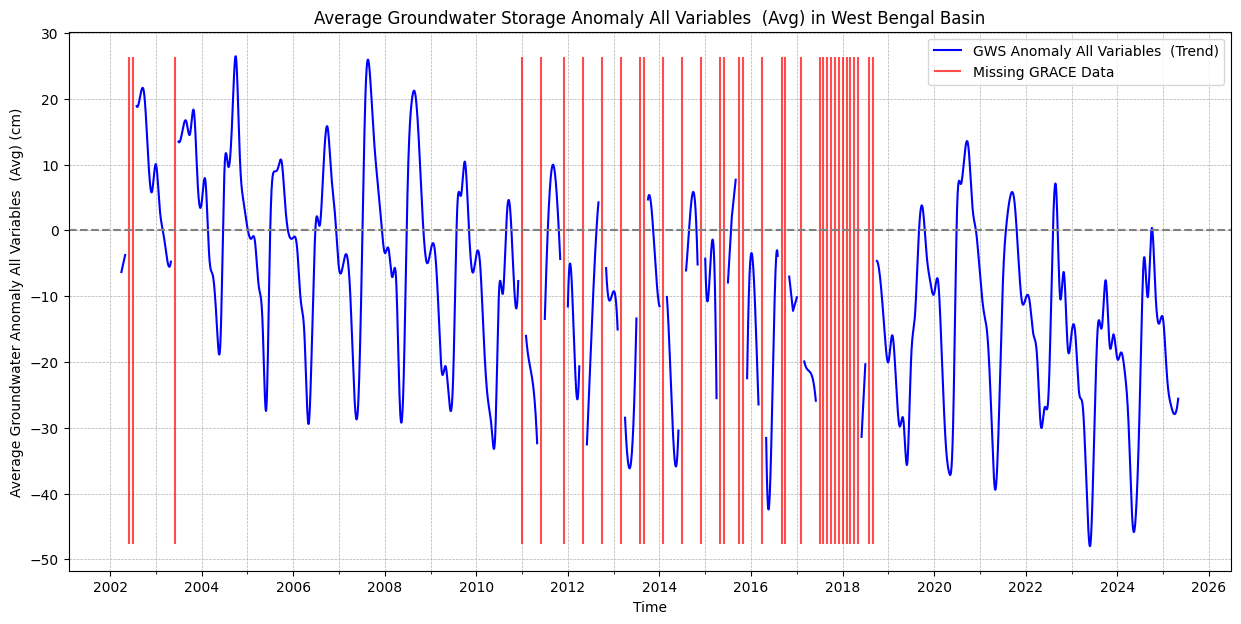

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline

# --- Steps 1-4: Load and prepare the data (these are unchanged) ---
final_df = pd.read_csv('GWS_Ensemble_Final_Results_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

gws_basin_avg = final_df.groupby('time')['GWS_ensemble_anomaly_cm'].mean().reset_index()

gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(),
    end=gws_basin_avg['time'].max(),
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')


# --- Step 5: Create the discontinuous smooth curve plot ---
print("Generating the final discontinuous smooth curve plot...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# Separate data into points that exist and points that are missing
has_data = plot_df.dropna().sort_values(by='time').drop_duplicates(subset='time')
missing_data = plot_df[plot_df['GWS_ensemble_anomaly_cm'].isna()]

# --- THE FIX: Identify contiguous blocks of data ---
# A new block is identified where the gap between dates is more than a month
has_data['block'] = (has_data['time'].diff() > pd.Timedelta('32 days')).cumsum()

# Loop through each block and plot it as a separate smooth curve
for block_id, group in has_data.groupby('block'):
    # Spline interpolation needs at least a few points to work
    if len(group) > 3:
        # Convert dates to a numerical format for interpolation
        x_numeric = group['time'].astype(np.int64) // 10**9
        y = group['GWS_ensemble_anomaly_cm']
        
        spline = CubicSpline(x_numeric, y)
        
        x_numeric_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 100 * len(group))
        x_datetime_smooth = pd.to_datetime(x_numeric_smooth, unit='s')
        
        y_smooth = spline(x_numeric_smooth)
        
        # Use the same color for all segments, but don't repeat the label
        ax.plot(x_datetime_smooth, y_smooth, color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly All Variables (Trend)')
    elif len(group) > 1: # If too few points for a spline, draw a straight line
        ax.plot(group['time'], group['GWS_ensemble_anomaly_cm'], color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly All Variables  (Trend)')

# --- Plot the missing data as red vertical lines ---
if not missing_data.empty:
    data_min = has_data['GWS_ensemble_anomaly_cm'].min()
    data_max = has_data['GWS_ensemble_anomaly_cm'].max()
    ax.vlines(
        missing_data['time'],
        ymin=data_min if pd.notna(data_min) else -1,
        ymax=data_max if pd.notna(data_max) else 1,
        color='red',
        linestyle='-',
        linewidth=1.5,
        alpha=0.7,
        label='Missing GRACE Data'
    )

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_title('Average Groundwater Storage Anomaly All Variables  (Avg) in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly All Variables  (Avg) (cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Generating the final time-series plot...


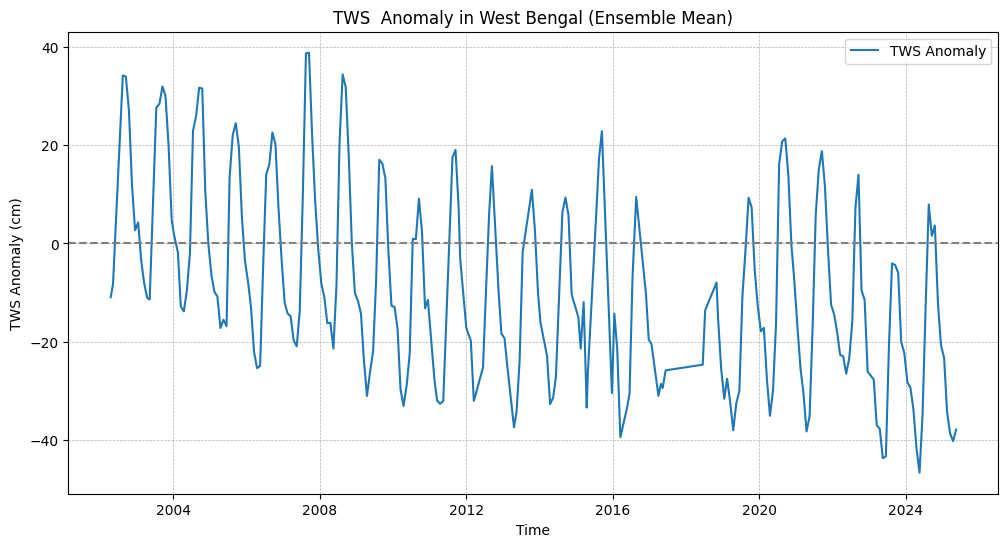

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final ensemble results file ---
final_file = 'GWS_Ensemble_Final_Results_cm.csv'
final_df = pd.read_csv(final_file)
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = final_df.groupby('time')['lwe_thickness_cm'].mean().reset_index()

# --- Step 3: Create the plot ---
print("Generating the final time-series plot...")

plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(gws_basin_avg['time'], gws_basin_avg['lwe_thickness_cm'], label='TWS Anomaly')

# Add a baseline and formatting
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('TWS  Anomaly in West Bengal (Ensemble Mean)')
plt.xlabel('Time')
plt.ylabel('TWS Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Display the plot
plt.show()